In [62]:
import numpy as np
import random
from sklearn.mixture import GaussianMixture
from typing import List
from dataclasses import dataclass
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D, proj3d
from matplotlib.patches import FancyArrowPatch

from tqdm.notebook import tqdm

import riepybdlib.manifold as rm
import riepybdlib.statistics as rs
from riepybdlib.angular_representations import Quaternion
from riepybdlib.statistics import RegularizationType

from ll4ma_util import torch_util, math_util, func_util

from multisensory_learning.learning import Learner, LearnerConfig
from multisensory_learning.learning.ortho6d_learner import Ortho6dConfig, Ortho6dLearner
from multisensory_learning.models import MDN
from multisensory_learning.models.loss import mdn_loss

import torch
from torch.utils.data import Dataset, DataLoader
from torch.distributions import MultivariateNormal, kl_divergence

%matplotlib notebook

device = 'cuda'

In [2]:
class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

        
def draw_frame(ax, R, origin=[0,0,0]):
    x = Arrow3D([origin[0], R[0,0] + origin[0]], [origin[1], R[0,1] + origin[1]], [origin[2], R[0,2] + origin[2]], 
                mutation_scale=20, lw=3, arrowstyle="-|>", color="r")
    y = Arrow3D([origin[0], R[1,0] + origin[0]], [origin[1], R[1,1] + origin[1]], [origin[2], R[1,2] + origin[2]], 
                mutation_scale=20, lw=3, arrowstyle="-|>", color="g")
    z = Arrow3D([origin[0], R[2,0] + origin[0]], [origin[1], R[2,1] + origin[1]], [origin[2], R[2,2] + origin[2]], 
                mutation_scale=20, lw=3, arrowstyle="-|>", color="b")
    ax.add_artist(x)
    ax.add_artist(y)
    ax.add_artist(z)
    

def visualize_rotation_clusters(R_clusters):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlim(-scale, scale)
    ax.set_ylim(-scale, scale)
    ax.set_zlim(-scale, scale)
   
    origin = [-1,0,0]
    for R_cluster in R_clusters:
        for R in R_cluster:
            draw_frame(ax, R, origin)
        origin[0] += 2

    plt.draw()
    plt.show()
    
    
def get_rotation_cluster(n_rotations, threshold=1.):
    key_R = math_util.random_rotation()
    qs = []
    Rs = []
    while len(Rs) < n_rotations:
        q = math_util.random_quat()
        R = math_util.quat_to_rotation(q)
        if math_util.geodesic_error(key_R, R) < threshold:
            riepy_q = Quaternion(q[3], q[:3])
            qs.append(riepy_q)
            Rs.append(R)
    return qs, Rs


class MDNDataset(Dataset):
    
    def __init__(self, samples):
        super().__init__()
        self.samples = samples
        
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        i, q = self.samples[idx]
        q = q.to_nparray()
        q = np.append(q[1:], q[0])  # (w, x, y, z) to (x, y, z, w)
        R = math_util.quat_to_rotation(q)
        sample = {'input': float(i), 'rotation': R}
        return sample
    

@dataclass
class MDNLearnerConfig(LearnerConfig):
    hidden_sizes: List[int] = func_util.lambda_field([128, 128])
    activation: str = 'relu'
    norm: str = 'layer'
    n_components: int = 1
    loss_print_interval: 1

        
class MDNLearner(Learner):
    
    def __init__(self, config, ortho6d_learner, samples, set_train=False, set_eval=False):
        self.ortho6d_learner = ortho6d_learner
        self.ortho6d_learner.set_eval()
        super().__init__(config, samples, set_train=set_train, set_eval=set_eval)
        
    def set_models(self):
        self.models = {
            'mdn': MDN(1, 6, self.config.hidden_sizes, self.config.n_components, 
                       self.config.activation, self.config.norm).double()
        }
        super().set_models()
        
    def apply_models(self, batch):
        inputs = batch['input'].unsqueeze(-1)
        return self.models['mdn'](inputs)
    
    def compute_loss(self, batch, outputs):
        target = self.ortho6d_learner.apply_models(batch, True)['ortho6d']
        loss = mdn_loss(target, *outputs)
        loss_dict = {'mdn': loss.item()}
        return loss, loss_dict
        
    def get_data_loaders(self, val_size=0.1, drop_last_batch=False):
        return super().get_data_loaders(val_size, drop_last_batch, dataset_type=MDNDataset)
    
    def save_checkpoint(self, *args, **kwargs):
        pass

# Generate Data

<IPython.core.display.Javascript object>


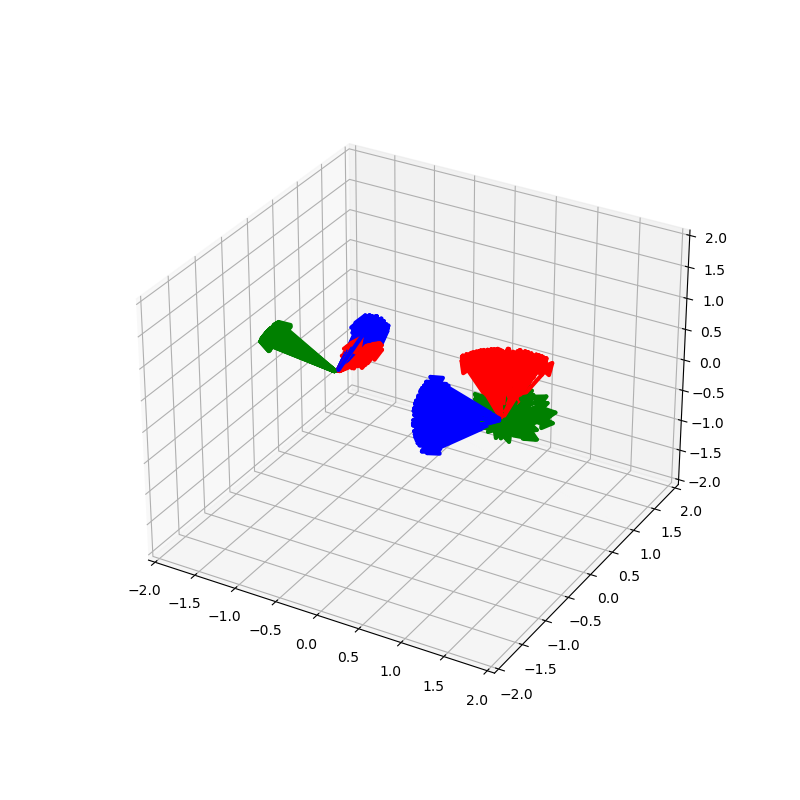

In [8]:
scale = 2
thresholds = [0.2, 0.6]
n_clusters = 2
n_per_cluster = 100
   
q_clusters = []
R_clusters = []
for i in range(n_clusters):
    qs, Rs = get_rotation_cluster(n_per_cluster, thresholds[i])
    q_clusters.append(qs)
    R_clusters.append(Rs)
    
visualize_rotation_clusters(R_clusters)

# Fit SO(3) GMM (from riepybdlib)

2
EM converged in 2 steps
(0.65, [-0.06994588 -0.22014932 -0.7222153 ]) 0.4999999999999972
(0.62, [ 0.0652035   0.72354342 -0.29949618]) 0.5000000000000028


<IPython.core.display.Javascript object>


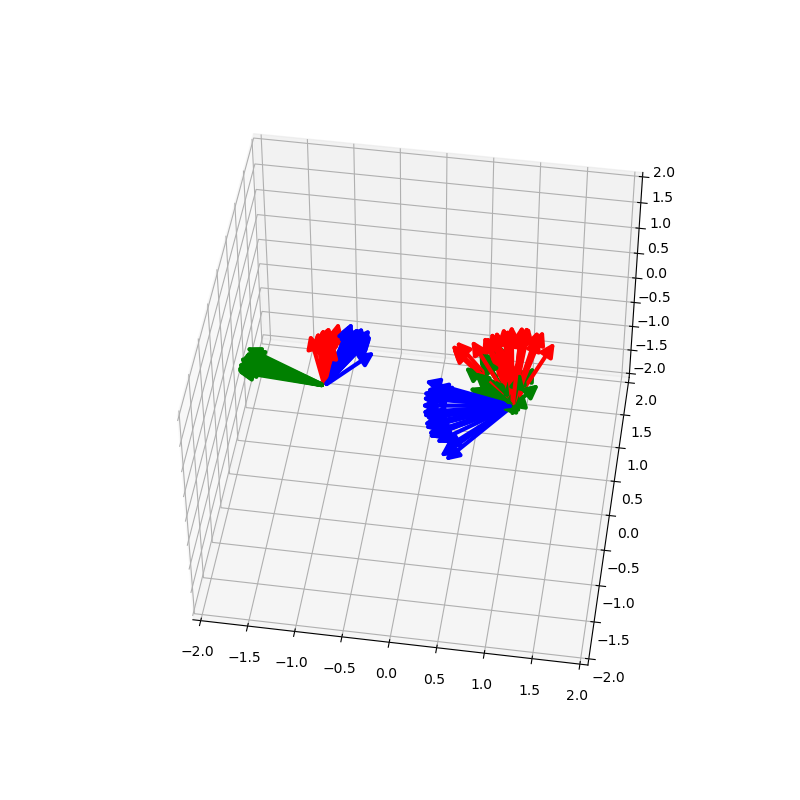

In [9]:
n_samples_per_cluster = 25
conv_thresh = 1e-10
reg_lambda = 1e-4
reg_type = RegularizationType.SHRINKAGE
# reg_type = RegularizationType.DIAGONAL
minsteps = 1

m_quat = rm.get_quaternion_manifold('quat')
gmm = rs.GMM(m_quat, n_clusters)

# Try fitting prior Gaussians
mu = m_quat.id_elem
sigma = np.eye(m_quat.n_dimT)
gaussians = []
for q_cluster in q_clusters:
    g = rs.Gaussian(m_quat, mu, sigma)
    g.mle(q_cluster)
    gaussians.append(g)
gmm.gaussians = gaussians
print(len(gmm.priors))

all_data = [q for q_cluster in q_clusters for q in q_cluster]
random.shuffle(all_data)
gmm.fit(all_data, convthres=conv_thresh, minsteps=minsteps, reg_lambda=reg_lambda, reg_type=reg_type)

sample_q_clusters = []
for i, gauss in enumerate(gmm.gaussians):
    print(gauss.mu, gmm.priors[i])
    samples = []
    for _ in range(n_samples_per_cluster):
        q_sample = gauss.sample().to_nparray()
        samples.append(np.append(q_sample[1:], q_sample[0]))  # want (x,y,z,w) instead of (w,x,y,z)
    sample_q_clusters.append(samples)
    
sample_R_clusters = [[math_util.quat_to_rotation(q) for q in cluster] for cluster in sample_q_clusters]
visualize_rotation_clusters(sample_R_clusters)

# Learn SO(3) MDN with Ortho6d representation

In [10]:
multicomponent = True
n_epochs = 100
hidden_sizes = [128, 128]
ortho6d_checkpoint = '/media/ssd_data/ortho6d_cp/ortho6d_010.pt'

ortho6d_config = Ortho6dConfig(checkpoint=ortho6d_checkpoint)
ortho6d_learner = Ortho6dLearner(ortho6d_config, set_eval=True)

if multicomponent:
    samples = [(0, q) for i, qs in enumerate(q_clusters) for q in qs] # Trying multi-component
else:
    samples = [(i, q) for i, qs in enumerate(q_clusters) for q in qs]

config = MDNLearnerConfig()
config.n_components = 2 if multicomponent else 1
config.n_epochs = n_epochs
config.hidden_sizes = hidden_sizes
learner = MDNLearner(config, ortho6d_learner, samples, set_train=True)
learner.train()

  E30-V: mdn=-4.956019: 100%|██████████| 20/20 [00:00<00:00, 283.72it/s]
Epoch    30: reducing learning rate of group 0 to 1.0000e-04.
  E55-T: mdn=-5.004493: 100%|██████████| 180/180 [00:00<00:00, 2124.43it/s]


  E60-V: mdn=-5.761883: 100%|██████████| 20/20 [00:00<00:00, 303.24it/s]
Epoch    60: reducing learning rate of group 0 to 1.0000e-05.
  E100-V: mdn=-5.819178: 100%|██████████| 20/20 [00:00<00:00, 298.82it/s]


# Visualize SO(3) MDN samples

<IPython.core.display.Javascript object>


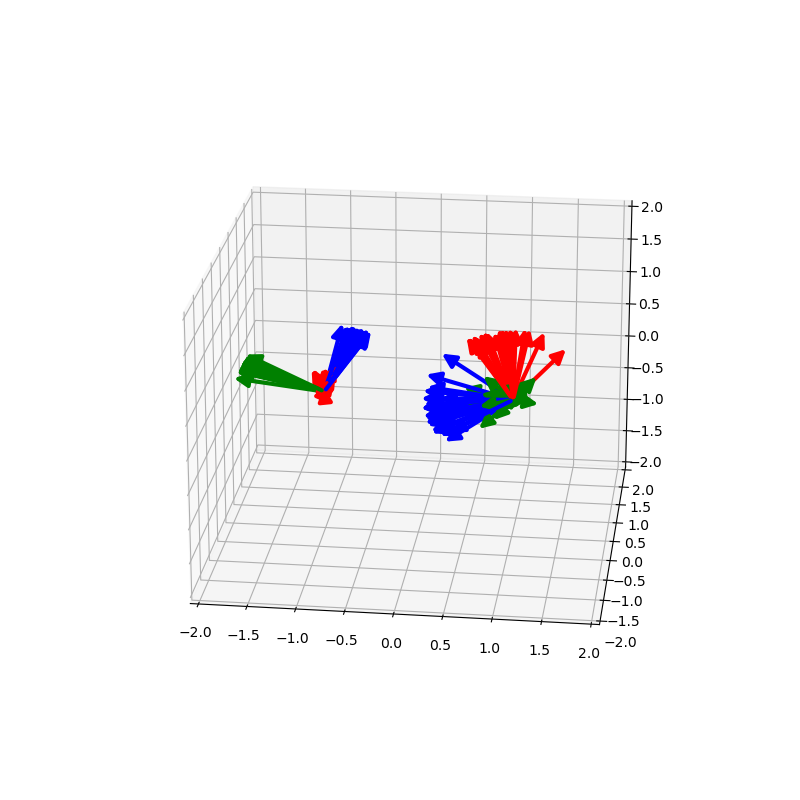

In [11]:
n_mdn_samples = 25

learner.set_eval()

mdn_R_clusters = []

if multicomponent:
    inputs = {'input': torch.tensor(0).double().view(1, 1).to(device)}
    alpha, mu, sigma = learner.apply_models(inputs)
    for i in range(n_clusters):
        mvn = MultivariateNormal(mu[:,:,i], scale_tril=sigma[:,:,:,i])
        mdn_ortho6d_samples = mvn.sample((n_mdn_samples,)).squeeze(1)
        mdn_R_samples = torch_util.ortho6d_to_rotation(mdn_ortho6d_samples)
        mdn_R_samples = [R.cpu().numpy() for R in mdn_R_samples]
        mdn_R_clusters.append(mdn_R_samples)
else:
    for i in range(n_clusters):
        inputs = {'input': torch.tensor(i).double().view(1, 1).to(device)}
        alpha, mu, sigma = learner.apply_models(inputs)
        mvn = MultivariateNormal(mu[:,:,0], scale_tril=sigma[:,:,:,0])
        mdn_ortho6d_samples = mvn.sample((n_mdn_samples,)).squeeze(1)
        mdn_R_samples = torch_util.ortho6d_to_rotation(mdn_ortho6d_samples)
        mdn_R_samples = [R.cpu().numpy() for R in mdn_R_samples]
        mdn_R_clusters.append(mdn_R_samples)
        
visualize_rotation_clusters(mdn_R_clusters)

In [67]:
gt_orthos = []
for R_cluster in R_clusters:
    batch = {'rotation': torch.tensor(R_cluster).to(device)}
    with torch.no_grad():
        orthos = ortho6d_learner.apply_models(batch, True)['ortho6d'].cpu().numpy()
        for ortho in orthos:
            gt_orthos.append(ortho)
    
ortho_gmm = GaussianMixture(n_components=2)
ortho_gmm.fit(gt_orthos)
ortho_mus = ortho_gmm.means_
ortho_sigmas = ortho_gmm.covariances_

if multicomponent:
    inputs = {'input': torch.tensor(0).double().view(1, 1).to(device)}
    alpha, mu, sigma = learner.apply_models(inputs)
    mdn_mus = mu.squeeze(0)
    mdn_sigmas = sigma.squeeze(0)
    for i in range(n_clusters):
        mvn = MultivariateNormal(mu[:,:,i], scale_tril=sigma[:,:,:,i])
else:
    mdn_mus = []
    for i in range(n_clusters):
        inputs = {'input': torch.tensor(i).double().view(1, 1).to(device)}
        alpha, mu, sigma = learner.apply_models(inputs)
        
        mdn_mus.append(mu.squeeze())
        mvn = MultivariateNormal(mu[:,:,0], scale_tril=sigma[:,:,:,0])
    mdn_mus = torch.stack(mdn_mus)

    
# Figure out min KL, this is a proxy computation to get around no KL for GMM
for i in range(n_clusters):
    for j in range(n_clusters):
        ortho_mvn = MultivariateNormal(torch.tensor(ortho_mus[i]).to(device), 
                                       covariance_matrix=torch.tensor(ortho_sigmas[i]).to(device))
        mdn_mvn = MultivariateNormal(mdn_mus[:,j], scale_tril=mdn_sigmas[:,:,j])
        kl = kl_divergence(ortho_mvn, mdn_mvn).item()
        print(kl)

665.7655833921148
3.293661823598499
6.135208543536661
114.2857895923127
